# Comparing Confidence Sequences for IID Mean

Comparing CM-EB, Stitching EB, PM-EB, CM-H, Stitching H, PM-H, and Asymptotic CS for IID mean (of differences).

Generally speaking, the order of widths is expected to be (small to large): Asymptotic CS, CM-EB / PM-EB, Stitching EB, CM-H / PM-H, and Stitching H.

In [1]:
import os.path
from collections import OrderedDict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns

import comparecast as cc

In [2]:
cc.set_theme()

In [3]:
os.makedirs("plots/iid_mean", exist_ok=True)

## Data: IID Differences in Betas

For $i = 1, 2, \dotsc, 10,000$:
$$
\delta_i \overset{IID}{\sim} \mathrm{Beta}(30, 10) - \mathrm{Beta}(10, 30)
$$

Note that $-1 \leq \delta_i \leq 1$ a.s., and $\mathbb{E}[\delta_i] = \frac{30}{30+10} - \frac{10}{10+30} = \frac{1}{2}$.

In [4]:
# setup
alpha = 0.05

# data: Beta(a, b) - Beta(b, a)
a, b = 30, 10  # beta hyperparameters
rng = np.random.default_rng(1)
T = 10000
lo, hi = -1., 1.
xs = rng.beta(a, b, size=T) - rng.beta(b, a, size=T)

# Sample mean (centers)
ts = np.arange(1, len(xs) + 1)
sums = np.cumsum(xs)
mus = sums / ts

# Sample variance (estimate of intrinsic time)
shifted_mus = mus.copy()
shifted_mus[1:], shifted_mus[0] = mus[:-1], mus[0]
vs = np.maximum(1., np.cumsum((xs - shifted_mus) ** 2))

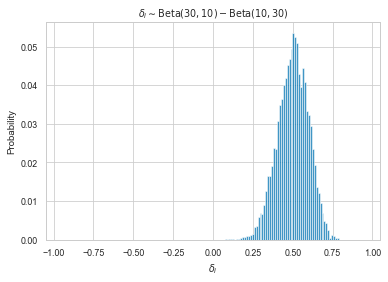

In [5]:
# Plot data, S_t and V_t
df = pd.DataFrame({
    "t": ts,
    "x": xs,
    "s": sums,
    "v": vs,
})

ax = sns.histplot(x="x", stat="probability", data=df)
ax.set(
    title=r"$\delta_i \sim \mathrm{Beta}(%d, %d) - \mathrm{Beta}(%d, %d)$" % (a, b, b, a),
    xlim=(-1.05, 1.05),
    xlabel=r"$\delta_i$",
)

plt.savefig("plots/iid_mean/data.pdf")
None

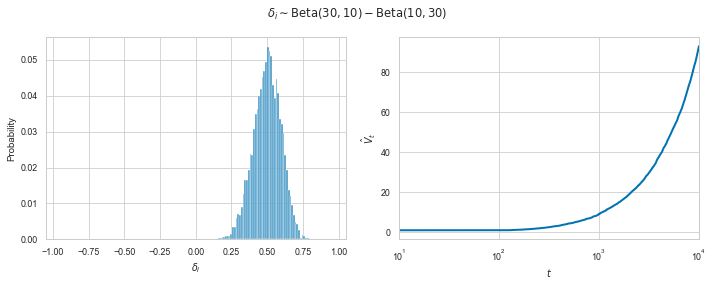

In [6]:
# double plot
fig, ax = plt.subplots(1, 2, figsize=(10, 4), facecolor="white")
sns.histplot(x="x", stat="probability", data=df, ax=ax[0])
ax[0].set(
    xlim=(-1.05, 1.05),
    xlabel=r"$\delta_i$",
)
sns.lineplot(x="t", y="v", linewidth=2, data=df, ax=ax[1])
ax[1].set(
    xscale="log",
    xlim=(10**1, 10**4),
    #yscale="log",
    xlabel=r"$t$",
    ylabel=r"$\hat{V}_t$",
)

fig.suptitle(r"$\delta_i \sim \mathrm{Beta}(%d, %d) - \mathrm{Beta}(%d, %d)$" % (a, b, b, a))
fig.tight_layout()

fig.savefig("plots/iid_mean/data_with_vs.pdf")
None

## Comparing Uniform Boundaries for Empirical Bernstein CS

Given that $\hat{V}_t$ ranges up to $10^3$, we test $v_\mathrm{opt} \in \{0.1, 1, 10, 100, 1000\}$.

In [7]:
df_rows = []
for log_v in [-1, 0, 1, 2, 3]:
    v = 10 ** log_v
    lcbs, ucbs = cc.confseq_eb(xs, alpha, lo, hi, 
                               boundary_type="mixture", v_opt=v)
    df_rows.extend([
        {
            "Time": t, 
            r"$\hat{V}_t$": v_t,
            "Boundary": "Mixture",
            r"$v_{{opt}}$": v,
            "Width": ucb - lcb,
        }
        for t, (v_t, lcb, ucb) in enumerate(zip(vs, lcbs, ucbs), 1)
    ])

s, eta = 1.4, 2
for log_v in [1]:  # optimal
    v = 10 ** log_v
    lcbs, ucbs = cc.confseq_eb(xs, alpha, lo, hi, 
                               boundary_type="stitching", v_min=v, s=s, eta=eta)
    df_rows.extend([
        {
            "Time": t, 
            r"$\hat{V}_t$": v_t,
            "Boundary": "Stitching",
            r"$v_{{opt}}$": v,
            "Width": ucb - lcb,
        }
        for t, (v_t, lcb, ucb) in enumerate(zip(vs, lcbs, ucbs), 1)
    ])

df = pd.DataFrame(df_rows)

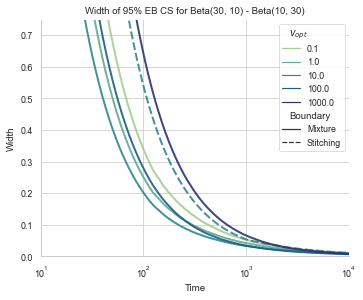

In [8]:
ax = sns.relplot(x="Time", y="Width", kind="line",
                 hue=r"$v_{{opt}}$", hue_norm=matplotlib.colors.LogNorm(),
                 style="Boundary", #col="BoundaryType", 
                 height=4, aspect=1.25, 
                 palette="crest", alpha=0.9, linewidth=2,
                 facet_kws={"legend_out": False},
                 data=df)
ax.set(
    title=f"Width of {100-100*alpha:g}% EB CS for Beta({a}, {b}) - Beta({b}, {a})",
    xscale="log",
    # xlim=(0.1, max(vs)),
    xlim=(10**1, 10**4),
    ylim=(0.0, 0.75),
)

ax.savefig("plots/iid_mean/boundary_comparison.pdf")
None

## Comparison Between Different Confidence Sequences

CM-EB, PM-EB, and Asymptotic CS.

In [9]:
v_opt = 10.

confseqs = OrderedDict([
    (f"Asymptotic ($t^*={v_opt:g}$)",
     cc.confseq_asymptotic(xs, alpha, t_star=v_opt, assume_iid=True)),

    (f"CM-EB ($v_{{opt}}={v_opt:g}$)",
     cc.confseq_eb(xs, alpha, lo, hi, boundary_type="mixture", v_opt=v_opt)),    
    (f"PM-EB ($c=0.5$)", cc.confseq_pm_eb(xs, alpha, c=0.5, lo=lo, hi=hi)),
    (f"Stitching EB ($v_{{opt}}={v_opt:g}$)", 
     cc.confseq_eb(xs, alpha, lo, hi, boundary_type="stitching", v_min=v_opt)),

    (f"CM-H ($v_{{opt}}={v_opt:g}$)",
     cc.confseq_h(xs, alpha, lo, hi, boundary_type="mixture", v_opt=v_opt)),
    (f"PM-H", cc.confseq_pm_h(xs, alpha, lo, hi)),
    (f"Stitching H ($v_{{opt}}={v_opt:g}$)", 
     cc.confseq_h(xs, alpha, lo, hi, boundary_type="stitching", v_min=v_opt)),
])

In [10]:
df_rows = []

for name, (lcbs, ucbs) in confseqs.items():
    df_rows.extend([
        {
            "Time": t,
            "CS": name,
            "LCB": lcb,
            "UCB": ucb,
            "Width": ucb - lcb,
        }
        for t, (lcb, ucb) in enumerate(zip(lcbs, ucbs), 1)
    ])

df = pd.DataFrame(df_rows)

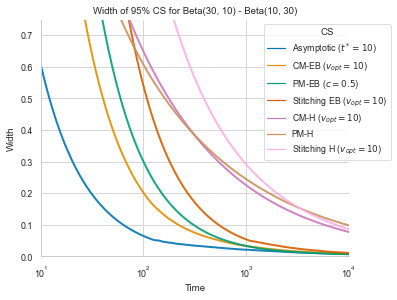

In [11]:
ax = sns.relplot(x="Time", y="Width", hue="CS", kind="line",
                 height=4, aspect=1.25, alpha=0.9, linewidth=2,
                 facet_kws={"legend_out": False},
                 data=df)
ax.set(
    title=f"Width of {100-100*alpha:g}% CS for Beta({a}, {b}) - Beta({b}, {a})",
    xscale="log",
    xlim=(10**1, 10**4),
    ylim=(0.0, 0.75),
)
ax._legend._loc = 1
ax._legend.set_bbox_to_anchor([1.15, 1])
ax.savefig("plots/iid_mean/cs_comparison.pdf")
None